# Required Installations of Spark & Java and set up of Environment Variables.

In [138]:
import os
# Find the latest version of spark 3.2 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.2.3'
spark_version = 'spark-3.2.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [3,141 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1,369 kB]
Err:13 http://archive.ubuntu.com/ubuntu bionic InRelease
  Could not connect 

In [139]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.5.1.jar

--2023-01-13 01:46:26--  https://jdbc.postgresql.org/download/postgresql-42.5.1.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1046770 (1022K) [application/java-archive]
Saving to: ‘postgresql-42.5.1.jar.2’

postgresql-42.5.1.j 100%[===================>]   1022K  5.81MB/s    in 0.2s    

2023-01-13 01:46:26 (5.81 MB/s) - ‘postgresql-42.5.1.jar.2’ saved [1046770/1046770]



# Load Amazon Data into Spark DataFrame
## Get the Country latitude and longitude details with GDP

In [140]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("FinalProject-WomenWellBeing").config("spark.driver.extraClassPath","/content/postgresql-42.5.1.jar").getOrCreate()


In [141]:
from pyspark import SparkFiles
url = "https://womenwellbeing.s3.us-west-1.amazonaws.com/Livwell_in_interpolated.csv"
spark.sparkContext.addFile(url)

livewell_df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("Livwell_in_interpolated.csv"), sep=",", header=True, inferSchema=True)
livewell_df.show()


+------------+------------+----+---------------------+----------------------+---------+-------------------+--------------------+------------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+----------------+-------------------+-----------+--------------+---------------+------------------+---------+------------+-------------+----------------+----------+-------------+-------------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------------+-------------------------+-------------------------+-------------------------+-----------------------+--------------------------+---------------------------------+------------------------------------+-----------------------+--------------------------+-------------------------------

### Load the dataframe with required columns and clean the data.

In [142]:
livewell_orginal_df =livewell_df
livewell_df.summary().show()




+-------+------------+------------+------------------+---------------------+----------------------+---------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------------+-------------------------+-------------------------+-------------------------+-----------------------+--------------------------+---------------------------------+-----------

## Convert PySpark dataframe to pandas data frame for etl process.

In [143]:
import pandas as pd

livewell_etl_df = livewell_df.toPandas()


livewell_etl_df

/content/spark-3.2.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,country_name,country_code,year,region_num_harmonized,region_name_harmonized,SurveyId,interview_year_mean,interview_month_mean,CMC_interview_mean,DM_age_15.19_p,...,EI_computer_p,EI_computer_p_se,DP_decide_no_contraception_p,DP_decide_no_contraception_p_se,EI_internet_day_p,EI_internet_day_p_se,EI_internet_week_p,EI_internet_week_p_se,EI_mobile_p,EI_mobile_p_se
0,Colombia,COL,1990,1,Atlantica,CO1990DHS,1990,7,1086.75,21.52,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,Colombia,COL,1990,2,Oriental,CO1990DHS,1990,7,1086.93,22.84,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Colombia,COL,1990,3,Central,CO1990DHS,1990,7,1086.76,19.49,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Colombia,COL,1990,4,Pacifica,CO1990DHS,1990,7,1086.59,21.86,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Colombia,COL,1990,5,Bogota,CO1990DHS,1990,5,1085.41,19.51,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7365,Senegal,SEN,2019,4,Kolda + Ziguinchor + Sedhiou (South),SN2019DHS,2019,8,1435.61,24.41,...,10.67,2.09,76.89,2.18,13.12,1.77,23.3,2.13,55.54,2.54
7366,Sierra Leone,SLE,2019,1,Eastern,SL2019DHS,2019,7,1434.66,21.11,...,2.06,0.34,44.78,2.5,3.01,0.5,5.56,0.62,33.34,1.65
7367,Sierra Leone,SLE,2019,2,Northern + North Western,SL2019DHS,2019,7,1434.77,22.77,...,2.36,0.3,52.67,2.31,3.43,0.41,5.44,0.54,34.53,1.36
7368,Sierra Leone,SLE,2019,3,Southern,SL2019DHS,2019,7,1434.62,21.73,...,2.33,0.36,63.38,2.04,5.5,0.5,7.19,0.66,32.44,1.54


### Drop the unnecessary columns and drop the null values and store the clean data into a new dataframe.

In [144]:
livewell_etl_df =livewell_etl_df.dropna()
livewell_etl_df = livewell_etl_df.drop(columns=['region_num_harmonized','region_name_harmonized','SurveyId','interview_year_mean','interview_month_mean','CMC_interview_mean'],axis=1)
livewell_etl_df.columns

Index(['country_name', 'country_code', 'year', 'DM_age_15.19_p',
       'DM_age_15.19_p_se', 'DM_age_20.24_p', 'DM_age_20.24_p_se',
       'DM_age_25.29_p', 'DM_age_25.29_p_se', 'DM_age_30.34_p',
       ...
       'EI_computer_p', 'EI_computer_p_se', 'DP_decide_no_contraception_p',
       'DP_decide_no_contraception_p_se', 'EI_internet_day_p',
       'EI_internet_day_p_se', 'EI_internet_week_p', 'EI_internet_week_p_se',
       'EI_mobile_p', 'EI_mobile_p_se'],
      dtype='object', length=401)

In [146]:
import numpy as np
# print(livewell_etl_df.dtypes[['country_name','DV_phys_or_sex_partner_p','DM_age_mean',	'DM_age_marr_mean',	'ED_educ_years_mean',	'FF_TFR']])
df = livewell_etl_df
mean_cols = list(df.columns[df.columns.str.endswith('_mean')])
mean_cols.insert(0,'year') 
mean_cols.insert(1,'country_name') 
mean_cols.insert(3,'DV_phys_or_sex_partner_p')
mean_cols.insert(4,"FF_TFR")

df = df.replace('NA',0)
df = df.astype({'DV_phys_or_sex_partner_p':'float',
                              'DM_age_mean':'float',	
                              'DM_age_marr_mean':'float',	
                              'ED_educ_years_mean':'float'})

df[mean_cols]
mean_indicators_df = df.loc[df['year']>=2000]

mean_indicators_df = mean_indicators_df.groupby(['country_name'])[mean_cols].mean()
mean_indicators_df =mean_indicators_df.reset_index()

mean_indicators_df = mean_indicators_df.loc[:,['country_name','DV_phys_or_sex_partner_p','DM_age_mean',	'DM_age_marr_mean',	'ED_educ_years_mean',	'FF_TFR']]
mean_indicators_df.to_csv("Livewell_Mean_Indicators.csv")

## Read the country data from PostgresSQL for further analysis.

In [147]:
!pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




### Connection credentials dictionary is created.



In [148]:

import psycopg2 as posgresSql
# define credentials 
credentials = {'POSTGRES_ADDRESS' : 'database-1.c1bq6ytovfoa.us-west-2.rds.amazonaws.com', # change to your endpoint
               'POSTGRES_PORT' : '5432', # change to your port
               'POSTGRES_USERNAME' : 'postgres', # change to your username
               'POSTGRES_PASSWORD' : 'postgres', # change to your password
               'POSTGRES_DBNAME' : 'postgres'} # change to your db name


# create connection and cursor    
conn = posgresSql.connect(host=credentials['POSTGRES_ADDRESS'],
                  database=credentials['POSTGRES_DBNAME'],
                  user=credentials['POSTGRES_USERNAME'],
                  password=credentials['POSTGRES_PASSWORD'],
                  port=credentials['POSTGRES_PORT'])

table_conn = conn.cursor()

In [149]:

import pandas as pd

# tablename = 'CountryDemographics'
# query = f"""SELECT * FROM {tablename};"""

query = """SELECT * FROM CountryGDPDemographics;"""

table_conn.execute(query=query)
country_df = pd.DataFrame(table_conn.fetchall(), columns= ['country_name','country_code','latitude','longitude','GDP'])

In [150]:
country_df

country_df.to_csv("CountryDemographics.csv")

## Combine the Country and Indicators ETL into one dataframe.

In [151]:

mean_indicators_df =mean_indicators_df.set_index('country_name')
country_df = country_df.set_index('country_name')

In [152]:

combined_df = mean_indicators_df.join(country_df)
combined_df.head()
combined_df = combined_df.dropna()
combined_df.to_csv('Country_Indicators.csv')

## Find the dependant features for the unsupervised learning and predict

In [153]:
!pip install Scikit-learn
!pip install sklearn
!pip install plotly
!pip install hvplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [171]:
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas

ML_Combined_df = combined_df
mean_indicators_df = mean_indicators_df.reset_index()
# Use get_dummies() to create variables for text features.
ML_features_df = pd.get_dummies(mean_indicators_df)
print(ML_features_df.shape)

ML_features_df

(52, 57)


,DV_phys_or_sex_partner_p,DM_age_mean,DM_age_marr_mean,ED_educ_years_mean,FF_TFR,country_name_Armenia,country_name_Bangladesh,country_name_Benin,country_name_Bolivia,country_name_Burkina Faso,...,country_name_South Africa,country_name_Tajikistan,country_name_Tanzania,country_name_Timor-Leste,country_name_Togo,country_name_Turkey,country_name_Uganda,country_name_Vietnam,country_name_Zambia,country_name_Zimbabwe
0,0.539786,31.333770,20.173957,10.634626,1.777382,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.534889,25.935778,15.317056,3.770611,2.608617,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.233981,28.747139,18.500306,2.392537,5.559406,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,29.193333,19.904167,8.025083,3.904192,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.460385,28.893461,17.414231,1.301154,6.067308,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,6.140357,27.701250,19.936250,4.436250,5.567125,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,16.259000,29.756852,19.504019,4.170741,3.502878,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,43.352547,27.703113,18.511604,6.927547,4.782745,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,38.545714,30.338791,20.130000,8.944835,2.284516,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,56.202273,28.156818,18.145455,5.460909,6.612091,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Apply standard scalar to fit and transform

In [172]:

# Creating the scaler instance
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()
ML_scaled_df = data_scaler.fit_transform(ML_features_df)
ML_scaled_df[:5]

array([[-0.74121753,  1.35105655,  0.91749994,  2.22245075, -1.94655803,
         7.14142843, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801, -0.14002801, -0.14002801, -0.14002801,
        -0.14002801, -0.14002801],
       [-0.60061375, -0.68393878, -2.2299908 , -0.62478579, -1.31241842,
        -0.14002801,  7.14142843, -0.14002801, -0.14002801, -0.14002801,
        -0.14002

## Feature reduction using PCA

In [176]:
# Using PCA to reduce dimension to three principal components.
# Initialize PCA model
pca = PCA(n_components=3)
# Get two principal components for the combined data.
ML_pca = pca.fit_transform(ML_scaled_df)
ML_pca.shape

(52, 3)

In [175]:
# Create a DataFrame with the three principal components.
# YOUR CODE HERE
ML_pca_df = pd.DataFrame(data=ML_pca,
columns={'PCA1','PCA2','PCA3'})
# ML_pca_df =ML_pca_df.set_index(ML_Combined_df.index)
ML_pca_df

,PCA1,PCA3,PCA2
0,3.669187,0.091953,-2.105340
1,-1.337056,-1.684766,-0.181221
2,-1.595005,-0.288428,-1.077806
3,1.617289,-0.118519,-1.190013
4,-2.675948,-0.126313,-1.213747
5,-0.327420,-0.067633,-0.148522
6,0.501395,0.365267,-0.536743
7,0.272630,2.468131,2.129353
8,2.951084,2.153595,0.737028
9,-1.177246,3.908015,2.792017


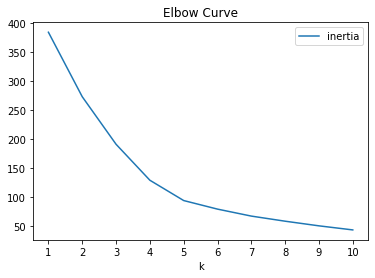

In [177]:
# Create an elbow curve to find the best value for K.
# Find the best value for K

from sklearn.cluster import KMeans
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of K values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(ML_pca_df)
    inertia.append(km.inertia_)


# Create the elbow curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

df_elbow.plot(x="k", y="inertia", xticks=k, title="Elbow Curve")
# plot = df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")
# plot
# df_elbow

In [178]:
# Initialize the K-Means model.
# YOUR CODE HERE
model = KMeans(n_clusters=4, random_state=5)
# Fit the model
# YOUR CODE HERE
model.fit(ML_pca_df)
# Predict clusters
# YOUR CODE HERE
predictions = model.predict(ML_pca_df)


len(predictions)

52

In [187]:
# clustered_df =pd.concat([crypto_original_df,crypto_pca_df], on ='Unnamed: 0')
clustered_df = mean_indicators_df.join(ML_pca_df)

clustered_df['class'] = predictions
# # Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)

clustered_df = clustered_df.join(country_df , on= "country_name")


clustered_df

(52, 10)


,country_name,DV_phys_or_sex_partner_p,DM_age_mean,DM_age_marr_mean,ED_educ_years_mean,FF_TFR,PCA1,PCA3,PCA2,class,country_code,latitude,longitude,GDP
0,Armenia,0.539786,31.333770,20.173957,10.634626,1.777382,3.669187,0.091953,-2.105340,3,AM,40.069099,45.038189,8.706873e+09
1,Bangladesh,2.534889,25.935778,15.317056,3.770611,2.608617,-1.337056,-1.684766,-0.181221,1,BD,23.684994,90.356331,1.645154e+11
2,Benin,1.233981,28.747139,18.500306,2.392537,5.559406,-1.595005,-0.288428,-1.077806,1,BJ,9.307690,2.315834,9.943232e+09
3,Bolivia,0.000000,29.193333,19.904167,8.025083,3.904192,1.617289,-0.118519,-1.190013,3,BO,-16.290154,-63.588653,2.302090e+10
4,Burkina Faso,1.460385,28.893461,17.414231,1.301154,6.067308,-2.675948,-0.126313,-1.213747,1,BF,12.238333,-1.561593,1.044752e+10
5,Burundi,6.140357,27.701250,19.936250,4.436250,5.567125,-0.327420,-0.067633,-0.148522,1,BI,-3.373056,29.918886,1.922410e+09
6,Cambodia,16.259000,29.756852,19.504019,4.170741,3.502878,0.501395,0.365267,-0.536743,3,KH,12.565679,104.990963,1.362157e+10
7,Cameroon,43.352547,27.703113,18.511604,6.927547,4.782745,0.272630,2.468131,2.129353,2,CM,7.369722,12.354722,2.795539e+10
8,Colombia,38.545714,30.338791,20.130000,8.944835,2.284516,2.951084,2.153595,0.737028,2,CO,4.570868,-74.297333,2.446231e+11
9,Congo Democratic Republic,56.202273,28.156818,18.145455,5.460909,6.612091,-1.177246,3.908015,2.792017,2,NaN,NaN,NaN,NaN


In [185]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    color="class",
    symbol="class",
    hover_name="country_name",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [188]:
clustered_df.to_csv("Women_Wellbeing_data.csv")